This is a _working_ notebook. See the `ccdControlIntro` notebook for a more narrative how-to. In this notebook, most cells have acquisition, processing, and plotting.

In [1]:
# All system imports
import logging
import time
import clocks
import fitsio

import numpy as np
import scipy
import scipy.optimize as opt

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
import power.PCM as PCM
reload(PCM)

pcm = PCM.PCM()
pcm.logger.setLevel(logging.DEBUG)

In [49]:
pcm.powerCmd('ampSwitch', False)
pcm.powerCmd('fee', True)
#pcm.powerCmd('fee', True)
#time.sleep(3)


DEBUG:PCM:sending '~06\r\n'
DEBUG:PCM:received 'Success'
DEBUG:PCM:sending '~13\r\n'
DEBUG:PCM:received 'Success'


'Success'

In [4]:
import testing.ampswitch as ampSwitch
reload(ampSwitch)

try:
    switch.close()
except:
    pass

switch = ampSwitch.AmpSwitch(host='10.1.1.21')
switch.readCoils()

RuntimeError: failed to connect to 10.1.1.21:502

In [50]:
# FEE connection and initialization.
# Initialize everything to some sane state.
import fee.feeControl as feeMod
reload(feeMod)

doLoad = False # '/home/pfs/feeMain (3).hex'
doCalib = False

logLevel = 20
fee = feeMod.FeeControl(logLevel=logLevel)
if doLoad:
    pcm.powerCmd('fee', turnOn=False)
    time.sleep(0.5)

    pcm.powerCmd('fee', turnOn=True)
    fee.sendImage(doLoad)

    time.sleep(2)
    pcm.powerCmd('fee', turnOn=False)
    time.sleep(1)
    pcm.powerCmd('fee', turnOn=True)
    time.sleep(4)
    fee = feeMod.FeeControl(logLevel=logLevel)
    fee.powerUp()
else:
    fee.powerUp()
    
time.sleep(1)

if doCalib:
    fee.raw('lp,read')
    for channel in 0,1:
        fee.doSet('bias', 'Pp', -1.0, channel=channel) 
        fee.doSet('bias', 'Sp', -1.0, channel=channel)
        fee.doSet('bias', 'Sn', 3.0, channel=channel)
    fee.raw('cal,CDS')
    fee.raw('cal,bias')
    fee.raw('sp,BT1')

    time.sleep(1)
    pcm.powerCmd('fee', turnOn=False)
    time.sleep(1)
    pcm.powerCmd('fee', turnOn=True)
    time.sleep(4)
    fee = feeMod.FeeControl(logLevel=logLevel)
    fee.powerUp()
    time.sleep(1)
    
if not doLoad and not doCalib:
    fee.powerUp()
    time.sleep(1)
    fee.raw('lp,read')


SUCCESS
SUCCESS
SUCCESS
SUCCESS
SUCCESS
SUCCESS
SUCCESS
SUCCESS
SUCCESS
SUCCESS


In [51]:
fee.zeroOffsets()
time.sleep(1)
fee.setOffsets(np.arange(8), [-10]*8, leg='p')
fee.setOffsets(np.arange(8), [10]*8, leg='n')

print fee.doGet('voltage','54VP')
print fee.doGet('offset','0p',0)

49.07
-9.98


In [23]:
fee.sendCommandStr('lp,read')
t0 = time.time()
stat = fee.getAllStatus()
t1 = time.time()

print "that took %0.3f s" % (t1-t0)

fee.printStatus()

feeCards = fee.statusAsCards()

that took 11.845 s
bias.ch0.Pp :  -1.26
bias.ch0.Pn :  3.01
bias.ch0.DGp :  4.99
bias.ch0.DGn :  4.99
bias.ch0.Sp :  -6.04
bias.ch0.Sn :  3.01
bias.ch0.SWp :  -6.04
bias.ch0.SWn :  5.03
bias.ch0.RGp :  -7.57
bias.ch0.RGn :  2.01
bias.ch0.OG :  -4.54
bias.ch0.RD :  -1.69
bias.ch0.OD :  -2.88
bias.ch0.BB :  46.57
bias.ch1.Pp :  -5.03
bias.ch1.Pn :  3.01
bias.ch1.DGp :  4.99
bias.ch1.DGn :  4.99
bias.ch1.Sp :  -6.04
bias.ch1.Sn :  3.01
bias.ch1.SWp :  -6.04
bias.ch1.SWn :  5.03
bias.ch1.RGp :  -7.57
bias.ch1.RGn :  2.01
bias.ch1.OG :  -4.54
bias.ch1.RD :  -7.72
bias.ch1.OD :  -19.47
bias.ch1.BB :  28.4
voltage.3V3M :  3.29
voltage.3V3 :  3.26
voltage.5VP :  4.96
voltage.5VN :  -4.93
voltage.5VPpa :  4.96
voltage.5VNpa :  -4.86
voltage.12VP :  11.57
voltage.12VN :  -11.67
voltage.24VN :  -23.03
voltage.54VP :  49.17
offset.ch0.0p :  -25.22
offset.ch0.1p :  -10.0
offset.ch0.2p :  -9.95
offset.ch0.3p :  -9.93
offset.ch0.0n :  10.04
offset.ch0.1n :  10.06
offset.ch0.2n :  10.05
offset.ch0.3n 

In [47]:
fee.sendCommandStr('sv,,off')
#fee.doSet('bias', 'BB', 20.0, channel=0)

'SUCCESS'

In [39]:
fee.sendCommandStr('lp,read')
fee.sendCommandStr('se,Vbb0,on')
fee.sendCommandStr('se,Vbb1,on')
#fee.doSet('bias', 'BB', 10.0, channel=0)
cmds = 'gb', 'rb'
chans = 'ch0', 'ch1'

for k in fee.allKeys('bias'):
    print "%-5s " % k,
    for cmd in cmds:
        for chan in chans:
            v = fee.sendCommandStr('%s,%s,%s' % (cmd, k, chan))
            print "%6s " % (v),
    print
    
#print fee.sendCommandStr('gb,Sn,ch1')
#print fee.sendCommandStr('rb,Sp,ch1')

Pp      -5.00   -5.00    0.00   -5.04 
Pn       3.00    3.00    3.01    3.01 
DGp      5.00    5.00    4.99    4.99 
DGn      5.00    5.00    4.99    4.99 
Sp      -6.00   -6.00   -6.04   -6.04 
Sn       3.00    3.00    3.01    3.01 
SWp     -6.00   -6.00   -6.04   -6.04 
SWn      5.00    5.00    5.03    5.03 
RGp     -7.50   -7.50   -7.57   -7.57 
RGn      2.00    2.00    2.01    2.01 
OG      -4.50   -4.50   -4.54   -4.54 
RD     -12.00  -12.00   -1.69   -8.12 
OD     -20.00  -20.00   -2.88  -19.44 
BB      30.00   30.00   46.48   28.31 


In [111]:
import sys

for i in range(5):
    print "ch0: ", fee.doGet('bias', 'BB', channel=0)
    print "ch1: ", fee.doGet('bias', 'BB', channel=1)

#print
#for i in range(2):
#    print "ch1: ", fee.doGet('bias', 'OD', channel=1)
#    print "ch0: ", fee.doGet('bias', 'OD', channel=0)


v0 = None
for i in range(0):
    v1 = fee.doGet('bias', 'OD', channel=0)
    if v0 != v1 or i%100 == 0:
        sys.stderr.write("%03d %s %s\n" % (i, v0, v1))
    v0 = v1
    
    #fee.setSerial('ADC', '03063061')
#fee.setSerial('PA0', '189')

fee.logger.setLevel(logging.INFO)

 ch0:  43.07
ch1:  43.07
ch0:  2.65
ch1:  43.07
ch0:  2.65
ch1:  43.07
ch0:  2.65
ch1:  43.07
ch0:  2.65
ch1:  43.07


In [78]:
switch.close()
del switch

NameError: name 'switch' is not defined

In [52]:
# FPGA connection and initialization.
# All the reloads are to make sure that new code gets picked up
import fpga as fpgaMod
import fpga.ccdFuncs as ccdFuncs
import fpga.nbFuncs as nbFuncs

reload(fpgaMod)
reload(fpgaMod.ccd)
reload(fpgaMod)

ccd = fpgaMod.CCD(adc18bit=1)  # adc18bit=2 reads the low bits.
ccd.pciReset()
print "FPGA version: 0x%08x" % (ccd.peekWord(0))

FPGA version: 0xbeefa070


In [19]:
# Load the clock tables. pfsClocks is used for each readout.
import clocks_001
import clocks_002
import clocks
reload(clocks_001)
reload(clocks_002)
reload(clocks)

pfsClocks = clocks_002.invertClocks()
pre, pix, post = pfsClocks()


In [27]:
reload(nbFuncs)

doGainCurve = False
if doGainCurve:
    fee.zeroOffsets()
    stepSize = 19.9*2
    statCols = slice(5,None)
    amps = np.arange(8)
    noffsets, nlevels = nbFuncs.gainCurve(ccd, fee, amps=amps, stepSize=stepSize, leg='n', 
                                          statCols=statCols, doUnwrap=65000)
    poffsets, plevels = nbFuncs.gainCurve(ccd, fee, amps=amps, stepSize=-stepSize, leg='p', 
                                          statCols=statCols, doUnwrap=65000)
    
    print
    nfits = nbFuncs.plotGains(noffsets, nlevels, amps=amps)
    print
    pfits = nbFuncs.plotGains(poffsets, plevels, amps=amps)

In [17]:
%pdb off
reload(ccdFuncs)
reload(nbFuncs)

allAmps = np.arange(8)
badAmps = []

dummyCcd = False
if not dummyCcd:
    goodAmps = np.arange(8)

    startStep = 5
    levels = 1000
else:
    goodAmps = np.arange(4) + 4
    
    startStep = 10
    levels = np.zeros(8)
    levels[4:] = [10000,25000,20000,15000]

ncols=300

doTune = True
if doTune:
    offs, devs, gains = nbFuncs.tuneLevels(ccd, fee, levels=levels, adjOffset=5, 
                                           amps=goodAmps,
                                           statCols=slice(2,None), 
                                           maxLoops=10, nrows=200, 
                                           startStep=startStep, 
                                           startOffset=startStep,
                                           sigTol=4, 
                                           clockFunc=pfsClocks, 
                                           legs='np', # useGains=nfits[:,0], 
                                           doZero=True, doUnwrap=65000)

    defOffsets = offs
else:
    #defOffsets = np.array([0.014]*8) # np.array([0.0151, 0.0143, 0.0147, 0.0152, 0.0142, 0.0154, 0.0141, 0.0146])
    defOffsets = np.array([0.0188, 0.0189, 0.0426, 0.0424, 0.0193, 0.0193, 0.0433, 0.0402])
    offs = defOffsets
    fee.zeroLevels()
    fee.setLevels(range(8), defOffsets)

Automatic pdb calling has been turned OFF

amps: [0 1 2 3 4 5 6 7]

====== read 0
offs (0): [5.0000 5.0000 5.0000 5.0000 5.0000 5.0000 5.0000 5.0000]
means(0): [499.5506 487.4927 476.1138 517.0773 471.4142 488.3106 495.9917 509.8599]
devs (0): [0.7064 0.7174 0.6970 0.7195 30.3279 30.1737 29.8491 29.8747]
done(0 of 10)   : [0 0 0 0 0 0 0 0]

offs!(0): [10.0000 10.0000 10.0000 10.0000 10.0000 10.0000 10.0000 10.0000]
doffs(0): [5.0000 5.0000 5.0000 5.0000 5.0000 5.0000 5.0000 5.0000]
gains(0): [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]

====== read 1
offs (1): [10.0000 10.0000 10.0000 10.0000 10.0000 10.0000 10.0000 10.0000]
means(1): [1154.1088 1142.8876 1131.0492 1172.4550 1127.3902 1143.9108 1151.6885 1165.0994]
devs (1): [0.7144 0.7256 0.7007 0.7107 30.2360 30.0539 29.8064 29.7147]
done(1 of 10)   : [0 0 0 0 0 0 0 0]

offs!(1): [8.8610 8.8718 9.0377 8.6462 9.0671 8.8643 8.8814 8.7020]
doffs(1): [-1.1390 -1.1282 -0.9623 -1.3538 -0.9329 -1.1357 -1.1186 -1.2980]
gains(1):

In [88]:
print switch.readCoils()

[True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


0099 41064.3 36342.2 32539.3 22849.0 40835.3 35924.3 32131.6 23275.4 2.39 1.98 1.53 0.91 5.19 5.01 4.62 3.56 OK
0299 41082.2 36359.7 32548.8 22849.5 40854.1 35945.9 32149.3 23276.6 2.23 1.94 1.51 0.96 5.16 5.08 4.75 3.41 OK
means: [41081.683 36359.298 32548.755 22849.577 40853.636 35944.632 32147.979 23276.826]
devs:  [3.221 2.677 2.016 1.037 5.736 5.579 5.024 3.475]
peak:  40854.0 38747 40881 27.0 90.0 0.0111111111111
file: /data/pfs/2015-07-02/PFSA-00001133.fits


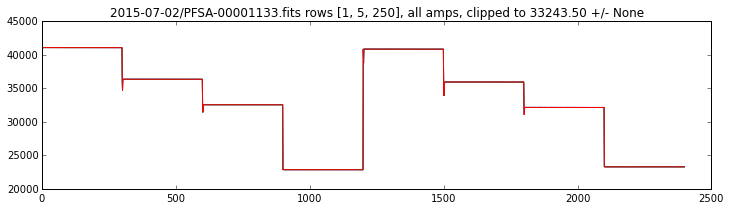

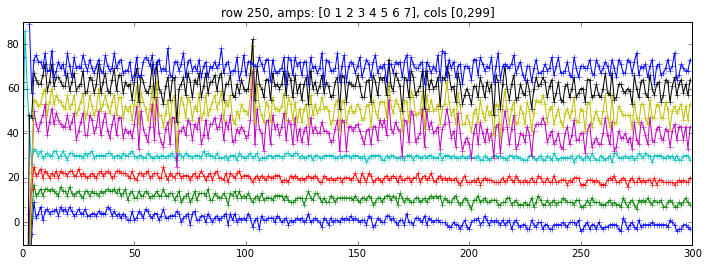

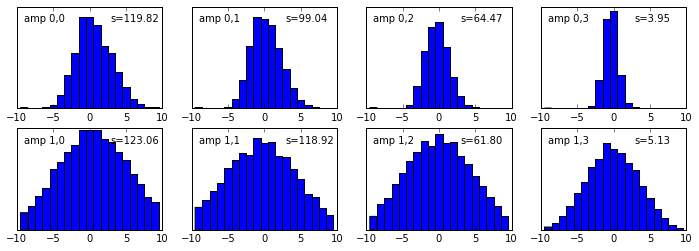

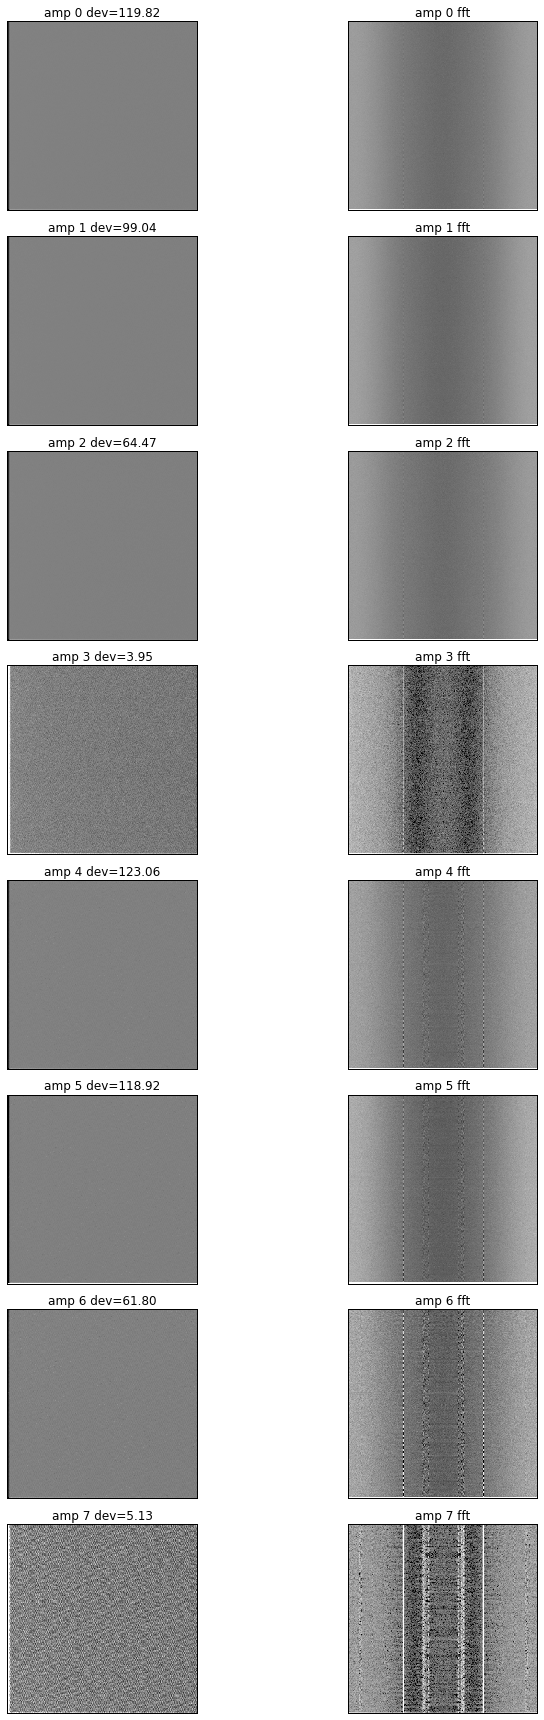

In [53]:
reload(ccdFuncs)
reload(nbFuncs)

goodAmps = np.arange(8) #[3,4,5,6, 7] # np.arange(8)
badAmps = []

# fee.raw('sb,SWn,ch1,0.0')

nrows = 300                # How many rows to read out.
ncols = 300
selectRows = slice(0,500)
selectCols = None # slice(5,5)
pcols = np.arange(0,ncols)    # Which cols to plot
statCols = np.arange(10,ncols) # Which cols to use for stats
prow = (selectRows.stop+1)/2
prows = [1, 5, prow]       # which rows to plot
fftAmps = []

figWidth = 12

argDict = dict(everyNRows=300, ampList=goodAmps, cols=statCols, ccd=ccd)

siggenAmp = None
if siggenAmp is None:
    try:
        switch.setCoils(off=range(16))
    except:
        pass
else:
    switch.chooseCoil(siggenAmp)

comment = 'pure test'
flushRead = True
doFile = None # '/data/pfs/2015-06-02/PFSA-00000954.fits'
doSave = True
if doFile:
    im = fitsio.read(doFile)
else:
    
    if flushRead:
        im, files = ccd.readImage(nrows=100, ncols=ncols, 
                                  rowFunc=ccdFuncs.rowStats, rowFuncArgs=argDict, 
                                  clockFunc=pfsClocks, doSave=False)
    im, files = ccd.readImage(nrows=nrows, ncols=ncols, 
                              rowFunc=ccdFuncs.rowStats, rowFuncArgs=argDict, 
                              clockFunc=pfsClocks, doSave=doSave,
                              comment=comment, addCards=feeCards)
if selectRows is not None:
    im = im[selectRows]
if selectCols is not None:
    im = im[:,selectCols]
    
im = im.astype('i4')
hi_w = np.where(im > 65500)
im[hi_w] -= 65535

if siggenAmp is None:
    amp4Mask = ccd.ampidx(4, im)
else:
    amp4Mask = ccd.ampidx(siggenAmp, im)

#amp6Mask = ccd.ampidx(6, im)
#im[:, amp6Mask] -= im[:, amp6Mask].mean()
#im[:, amp6Mask] += im[:, ccd.ampidx(4, im)].mean()

means,devs = nbFuncs.ampStats(im, ccd=ccd, cols=statCols)
print "means:", nbFuncs.fmtArr(means, format="%0.3f")
print "devs: ", nbFuncs.fmtArr(devs, format="%0.3f")
med4 = np.median(im[prow, amp4Mask])
max4 = np.max(im[prow, amp4Mask])
min4 = np.min(im[prow, amp4Mask])

inject = 0.3
print "peak: ", med4, min4, max4, max4-med4, (max4-med4)/inject, inject/(max4-med4)

# print "shape: %s dtype: %s" % (str(im.shape), im.dtype)
    
if len(files) > 0:
    path = files[0]
    imName = '/'.join(path.split('/')[-2:])
    print "file: %s" % (path)

#focusAmp = 0             # Which amp to focus on
#focusMask = ccd.ampidx(focusAmp, im)[pcols]

# plot one or more rows across the entire image
nbFuncs.plotRows(im, prows, imName=imName, figWidth=figWidth, pixRange=200 if siggenAmp is not None else None)

# plot one row for each the "good" amps
peaks = None # np.arange(1, ncols, 50)
if siggenAmp is not None:
    channel = siggenAmp/4
    amps0 = [siggenAmp]
    amps1 = goodAmps[np.where((goodAmps/4 == channel) & (goodAmps != siggenAmp))]
    amps2 = goodAmps[np.where(goodAmps/4 != channel)]

    nbFuncs.plotAmps(im, amps=amps0, row=prow, cols=pcols, 
                 plotOffset=10, fig=None, figWidth=figWidth, 
                 peaks=peaks, clipPeaks=True)

    nbFuncs.plotAmps(im, amps=amps1, row=prow, cols=pcols, 
                 plotOffset=100, fig=None, figWidth=figWidth, 
                 peaks=peaks, clipPeaks=True)

    nbFuncs.plotAmps(im, amps=amps2, row=prow, cols=pcols, 
                 plotOffset=10, fig=None, figWidth=figWidth)
else:
    nbFuncs.plotAmps(im, amps=goodAmps, row=prow, cols=pcols, 
                     plotOffset=10, fig=None, figWidth=figWidth, 
                     peaks=peaks, clipPeaks=True)

# f.axes[0].set_ylim(-50, 150)

# plot any bad amps individually
for a in badAmps:
    nbFuncs.plotAmps(im, amps=[a], row=prow, cols=pcols, figWidth=figWidth)

# show a grid of histograms.
hists = nbFuncs.ampHistGrid(im, ccd, cols=pcols, histRange=20, figWidth=figWidth)

# show a grid of raw amp images.
nbFuncs.rawAmpGrid(im, ccd, cols=pcols, figWidth=figWidth, showFfts=True)

fftAmps = [] # np.arange(8) # [1,2,5] # [5,6]
if len(fftAmps) > 0:    
    
    fftFig = plt.figure(figsize=(figWidth, figWidth/4))
    for a in fftAmps:
        fftFig = plt.figure(figsize=(figWidth, figWidth/4))
        fftMask = ccd.ampidx(a, im)[pcols]
        ampSeg = im[prow,fftMask]
        freqs, fft, peak_ii = ccdFuncs.plotTopPeriods(ampSeg, topN=3)


#fig.colorbar(pp)
#plt.tight_layout()